In [1]:
%matplotlib inline
# http://stackoverflow.com/questions/29452582/matplotlib-valueerror-width-and-height-must-each-be-below-32768-in-ipython-no
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Image, display, Audio

/Users/jjelosua/Developer/lanacion/ML_nisman/.venv/lib/python3.4/site-packages/librosa/core/audio.py:33: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [2]:
import os
import sys
cwd = os.getcwd()
preprocess_path = os.path.abspath(os.path.join(cwd, '../preprocess/scripts'))
sys.path.append(preprocess_path)
from featurize import preprocess, extract_chunks, get_local_maxima_idx

In [24]:
def classify_rings(smooth_data, lmax_idx):
    '''classify chunks as rings or non-rings'''
    SAMPLE_RATE = 8000
    RING_SEP_THRESHOLD = 2000
    RING_AMP_DIFF_THRESHOLD = 0.02
    
    ring_ref_amp = 0
    rings = np.zeros_like(lmax_idx)
    local_maxima = smooth_data[lmax_idx]
    # Take the time difference between each local maxima of the signal
    diff = np.diff(lmax_idx, n=1)

    ring_candidates = np.where((diff >= (SAMPLE_RATE*5)-RING_SEP_THRESHOLD) &
                               (diff <= (SAMPLE_RATE*5)+RING_SEP_THRESHOLD))[0]
    print('ring candidates: {}'.format(len(ring_candidates)+1))
    for idx in ring_candidates:
        # Check differences between the local maximum amplitudes is small
        if not ring_ref_amp:
            ring_ref_amp = local_maxima[idx]
        amp_lower = (ring_ref_amp - (RING_AMP_DIFF_THRESHOLD))
        amp_upper = (ring_ref_amp + (RING_AMP_DIFF_THRESHOLD))
        if (amp_lower <= local_maxima[idx+1] <= amp_upper):
            rings[idx] = 1
            rings[idx+1] = 1
        else:
            print('chunk in pos {} with amp: {} did not meet the amplitude criteria'.format(lmax_idx[idx],
                                                                                            local_maxima[idx]))
    return rings

In [4]:
# known to have good rings:
wav_path = '/Users/jjelosua/Developer/lanacion/ML_nisman/data/output/wavs/train/B-1009-2012-12-26-121627-4.wav'
img_path = '/Users/jjelosua/Developer/lanacion/ML_nisman/data/output/images/train/B-1009-2012-12-26-121627-4.png'

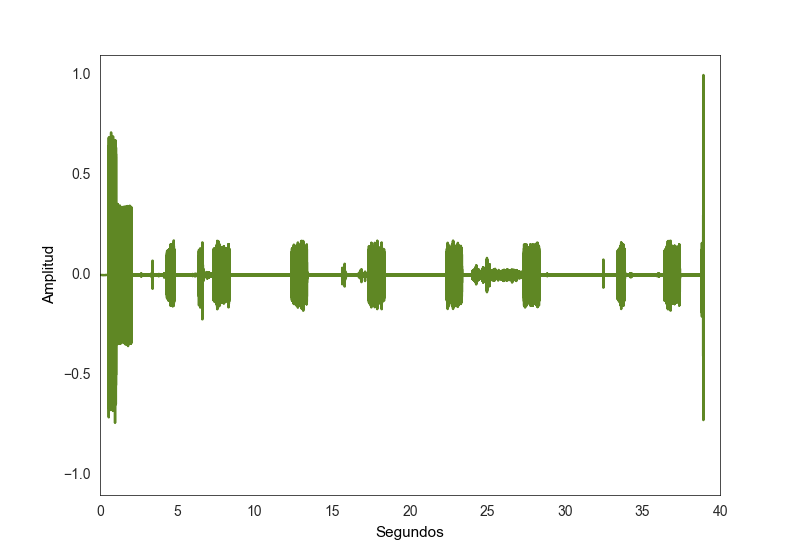

In [5]:
im = Image(filename=img_path)
display(im)

In [7]:
# load audio file with librosa
data, sr = librosa.load(wav_path, sr=None)

In [8]:
# Play it back with IPython.display.Audio!
Audio(data=data, rate=sr)

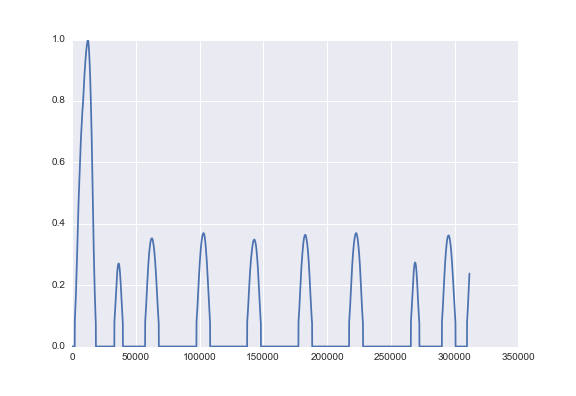

In [6]:
smooth_data = preprocess(wav_path)
silences, nonsilences = extract_chunks(smooth_data)
plt.plot(smooth_data)

In [25]:
# Classify rings
lmax_idx = get_local_maxima_idx(nonsilences)
rings = classify_rings(smooth_data, lmax_idx)
rings

ring candidates: 5
chunk in pos 62632 with amp: 0.3526885693858974 did not meet the amplitude criteria
chunk in pos 142895 with amp: 0.3485492325813494 did not meet the amplitude criteria
chunk in pos 182844 with amp: 0.364048883991626 did not meet the amplitude criteria


array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

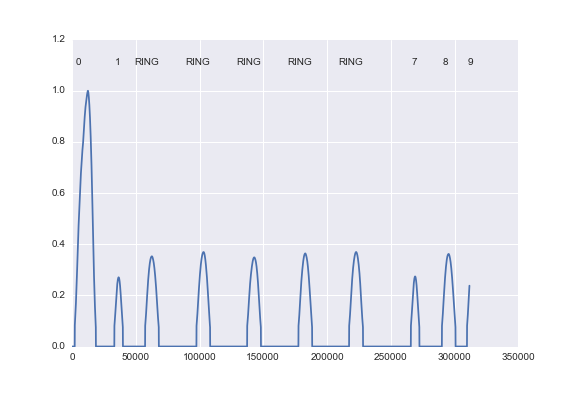

In [21]:
# Plot audio with detected rings
smooth_data = preprocess(wav_path)
silences, nonsilences = extract_chunks(smooth_data)
plt.ylim([0, 1.2])
for i, (pos, ns) in enumerate(nonsilences):
    x = pos
    # Check if it is a ring
    if rings[i]:
        plt.text(x=x-8000, y=1.1, s='RING')
    else:
        plt.text(x=x+1000, y=1.1, s=i)
plt.plot(smooth_data)